In [1]:
import sys
sys.path.append("..") #to access custom "utils" package

In [2]:
import os
import pandas as pd
import seaborn as sns
import utils.similarity_index as similarity_index
from scipy import stats
import statsmodels as sms
import numpy as np

In [3]:
from tqdm.notebook import tqdm

In [4]:
OUT_DIR = os.path.join("..", r"scripts/outputs")
XL_PATH = os.path.join("..", r"inputs/radiomicsFeatures.csv")

In [5]:
num_repeats = 100

feats_df = pd.read_csv(XL_PATH)

In [6]:
stability_df = {"fs_method":[], "similarity_measure":[], "top_k":[], "estimate":[]}

fs_methods = ["random", "oneDSAE", "bayesianDSAE", "ensembleDSAE", "backwardSFS/LogisticRegression", "backwardSFS/SVC", "backwardSFS/RandomForestClassifier", "backwardSFS/MLPClassifier"]
similarity_methods = {"jaccard":similarity_index.jaccard, "dice":similarity_index.dice, "kuncheva":similarity_index.kuncheva, "mwm":similarity_index.mwm}
top_ks = [5, 10, 15, 20, 25]


for fs_method in tqdm(fs_methods):

    for i in range(num_repeats):
    
        for j in range(i+1, num_repeats):
    
            df1 = pd.read_csv(os.path.join(OUT_DIR, fs_method, f"rank_df{i}.csv"))
            df2 = pd.read_csv(os.path.join(OUT_DIR, fs_method, f"rank_df{j}.csv"))

            for similarity_measure, similarity_fn in similarity_methods.items():

                for k in top_ks:

                    estimate = similarity_fn(df1=df1, df2=df2, k=k, feats_df = feats_df)

                    stability_df["fs_method"].append(fs_method)
                    stability_df["similarity_measure"].append(similarity_measure)
                    stability_df["top_k"].append(k)
                    stability_df["estimate"].append(estimate)

                
            estimate = similarity_index.global_spearman(df1, df2)

            stability_df["fs_method"].append(fs_method)
            stability_df["similarity_measure"].append("global_spearman")
            stability_df["top_k"].append("NA")
            stability_df["estimate"].append(estimate)

  0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
stability_df = pd.DataFrame(stability_df)

In [8]:
stability_df.to_csv("stability_df.csv", index=False)

In [7]:
stability_df = pd.read_csv("stability_df.csv", keep_default_na=False)

mean_stability_df = stability_df.groupby(by=["fs_method", "similarity_measure", "top_k"]).mean()

In [8]:
mean_stability_df.groupby(by=["fs_method", "similarity_measure", "top_k"]).mean().xs("ensembleDSAE")

estimate
similarity_measure top_k          
dice               10     0.584384
                   15     0.678478
                   20     0.693980
                   25     0.702966
                   5      0.452404
global_spearman    NA     0.759545
jaccard            10     0.427787
                   15     0.525472
                   20     0.540514
                   25     0.547949
                   5      0.316288
kuncheva           10     0.531774
                   15     0.613305
                   20     0.605278
                   25     0.586937
                   5      0.419809
mwm                10     0.719755
                   15     0.777926
                   20     0.790118
                   25     0.795362
                   5      0.632293

In [9]:
stability_df.similarity_measure.unique()

array(['jaccard', 'dice', 'kuncheva', 'mwm', 'global_spearman'],
      dtype=object)

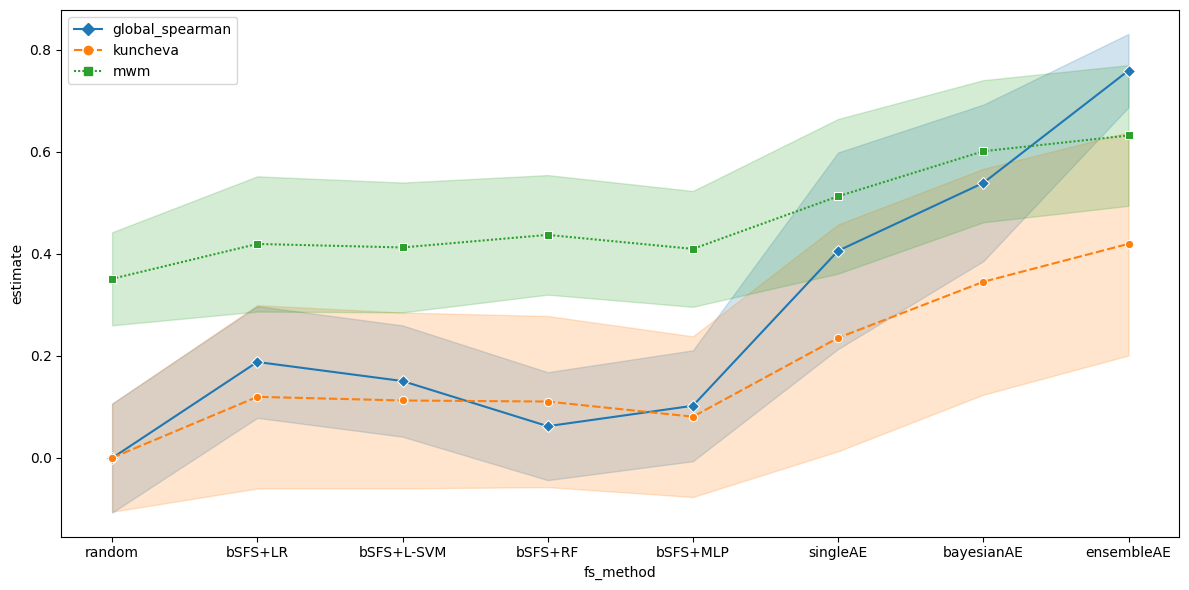

In [10]:
# Figure 1

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the custom order and mapping
custom_order = [
    "random",
    "backwardSFS/LogisticRegression",
    "backwardSFS/SVC",
    "backwardSFS/RandomForestClassifier",
    "backwardSFS/MLPClassifier",
    "oneDSAE",
    "bayesianDSAE",
    "ensembleDSAE"
]

label_mapping = {
    "random": "random",
    "backwardSFS/LogisticRegression": "bSFS+LR",
    "backwardSFS/SVC": "bSFS+L-SVM",
    "backwardSFS/RandomForestClassifier": "bSFS+RF",
    "backwardSFS/MLPClassifier": "bSFS+MLP",
    "oneDSAE": "singleAE",
    "bayesianDSAE": "bayesianAE",
    "ensembleDSAE": "ensembleAE"
}

# Filter and map
plot_data = stability_df[
    (stability_df.similarity_measure.isin(["global_spearman", "kuncheva", "mwm"])) &
    (stability_df.top_k.isin(["NA", "5"]))
].copy()

plot_data['fs_method'] = pd.Categorical(plot_data['fs_method'], categories=custom_order, ordered=True)
plot_data['fs_method'] = plot_data['fs_method'].map(label_mapping)

# # Calculate mean estimate for "random"
# random_mean = stability_df[
#     (stability_df.similarity_measure == "global_spearman") &
#     (stability_df.top_k == "NA") &
#     (stability_df.fs_method == "random")
# ]['estimate'].mean()

# Plotting
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=plot_data,
    x='fs_method',
    y='estimate',
    errorbar='sd',
    marker='o',
    hue='similarity_measure',
    style='similarity_measure',
    markers={
        'kuncheva': 'o',           # Circle
        'mwm': 's',                # Square
        'global_spearman': 'D'     # Diamond
    },
    hue_order=["global_spearman", "kuncheva", "mwm"],
    style_order=["global_spearman", "kuncheva", "mwm"]
)

# Horizontal line for random
# plt.axhline(y=random_mean, color='blue', linestyle='--', label='random')

# Draw horizontal lines for random for each similarity_measure
# random_means = stability_df[
#     (stability_df.top_k.isin(["NA",5])) &
#     (stability_df.fs_method == "random") &
#     (stability_df.similarity_measure.isin(["global_spearman", "kuncheva", "mwm"]))
# ].groupby("similarity_measure")["estimate"].mean()

# colors = {
#     'kuncheva': 'blue',
#     'mwm': 'orange',
#     'global_spearman': 'green'
# }

# for measure, mean in random_means.items():
#     plt.axhline(y=mean, linestyle='--', color=colors.get(measure, 'gray'), label=f'random ({measure})')


# plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig("stability_plot.tif", format="tiff", dpi=600)

plt.show()

In [ ]:
# Figure 2

# top-5 frequent features

In [11]:
fs_methods = ["backwardSFS/LogisticRegression", "backwardSFS/SVC", "backwardSFS/RandomForestClassifier", "backwardSFS/MLPClassifier", "oneDSAE", "bayesianDSAE", "ensembleDSAE"]
top_k = 5
freq_df = {}
freq_feats = {"fs_method":[], "freq_feats":[]}

for fs_method in fs_methods:
    
    freq_dict = {}
    
    for i in range(num_repeats):
     
        df = pd.read_csv(os.path.join(OUT_DIR, fs_method, f"rank_df{i}.csv"))
        
        selected_feats = df.sort_values(by="rank").head(top_k).feature.to_list()
        
        for feat in selected_feats:
            freq_dict[feat] = freq_dict.get(feat,0)+1

    feats, freq = zip(*freq_dict.items())
    
    freq_df[fs_method] = pd.DataFrame({"feature":feats, "frequency":freq})
    
    freq_feats["fs_method"].append(fs_method)
    freq_feats["freq_feats"].append(sorted(freq_df[fs_method].sort_values(by="frequency", ascending=False).head(top_k).feature.to_list()))
    

freq_feats = pd.DataFrame(freq_feats)

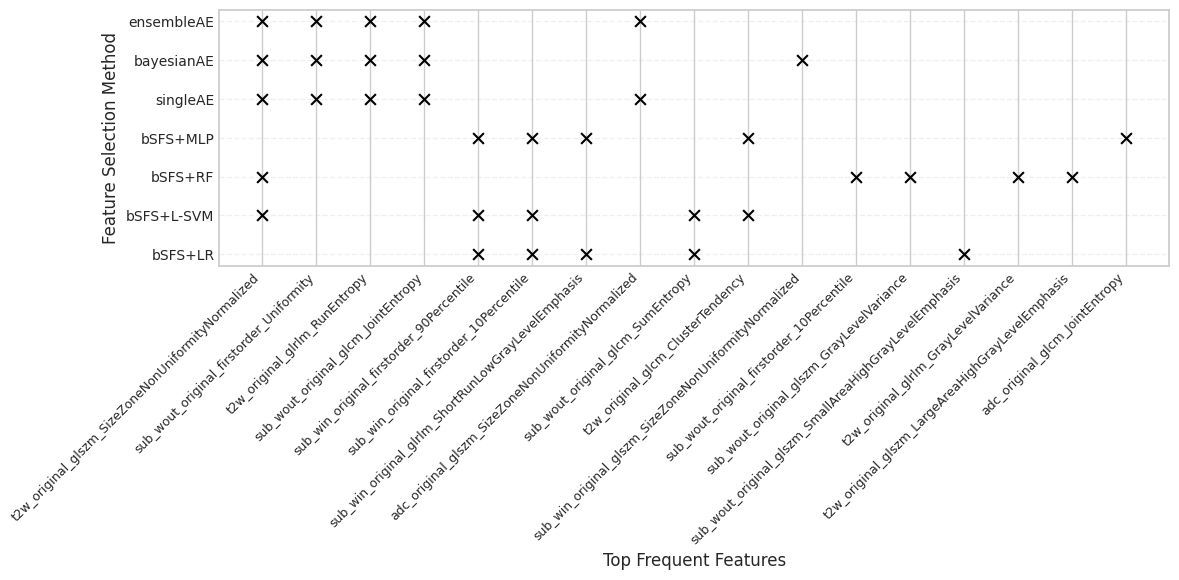

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn styling for a cleaner look
sns.set(style="whitegrid", context="notebook", font_scale=1.1)

df_exploded = freq_feats.explode("freq_feats")

# Pivot table creation (as you already did)
pivot = pd.crosstab(df_exploded["fs_method"], df_exploded["freq_feats"])

# Sort features by frequency (most to least)
top_features = pivot.sum().sort_values(ascending=False).index
pivot = pivot[top_features]

fs_methods = [
    "backwardSFS/LogisticRegression", "backwardSFS/SVC", 
    "backwardSFS/RandomForestClassifier", "backwardSFS/MLPClassifier", 
    "oneDSAE", "bayesianDSAE", "ensembleDSAE"
]
label_mapping = {
    "random": "random",
    "backwardSFS/LogisticRegression": "bSFS+LR",
    "backwardSFS/SVC": "bSFS+L-SVM",
    "backwardSFS/RandomForestClassifier": "bSFS+RF",
    "backwardSFS/MLPClassifier": "bSFS+MLP",
    "oneDSAE": "singleAE",
    "bayesianDSAE": "bayesianAE",
    "ensembleDSAE": "ensembleAE"
}

pivot = pivot.reindex(fs_methods)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot 'x' markers for each selected feature-method pair
for i, method in enumerate(pivot.index):
    for j, feat in enumerate(pivot.columns):
        if pivot.loc[method, feat]:
            ax.scatter(j, i, marker='x', color='black', s=60, linewidths=1.5)

# Format axes
y_labels = [label_mapping.get(method, method) for method in pivot.index]
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(y_labels, fontsize=10)
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns, rotation=45, ha='right', fontsize=9)

# Add labels and styling
ax.set_xlabel("Top Frequent Features", fontsize=12)
ax.set_ylabel("Feature Selection Method", fontsize=12)
# ax.set_title("Top Features Selected by Different Methods", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.tick_params(axis='both', which='major', length=0)

plt.tight_layout()

plt.savefig("freq_plot.tif", format="tiff", dpi=600)

plt.show()


### Correlation Analysis

In [13]:
# Correlation Analysis

import itertools
from scipy.optimize import linear_sum_assignment

def mwm(signature_dict, feats_df, corr_method='spearman'):
    
    fs_methods, signatures = zip(*signature_dict.items())
    
    df = pd.DataFrame(np.zeros((len(fs_methods), len(fs_methods))), index=fs_methods, columns=fs_methods)
    
    fs_methods = list(fs_methods)
    signatures = list(signatures)

    f = list(set(sum(signatures, [])))
    corr_matrix = feats_df[f].corr(method=corr_method).abs()
    
    pairs = list(itertools.product(fs_methods, repeat=2))
    
    for fs_method1, fs_method2 in pairs:
        
        
        f1_k, f2_k = signature_dict[fs_method1], signature_dict[fs_method2]
        cost_matrix = corr_matrix.loc[f1_k, f2_k]
        
        row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
        
        cost = cost_matrix.values[row_ind, col_ind].sum()/len(f1_k)
        
        df.loc[fs_method1, fs_method2] = cost

    return df

In [14]:
fs_methods = freq_feats.fs_method.to_list()
top_feats = freq_feats.freq_feats.to_list()
signature_dict = dict(zip(fs_methods, top_feats))

pearson_corr_df = mwm(signature_dict, feats_df, corr_method='pearson').abs()
spearman_corr_df = mwm(signature_dict, feats_df, corr_method='spearman').abs()

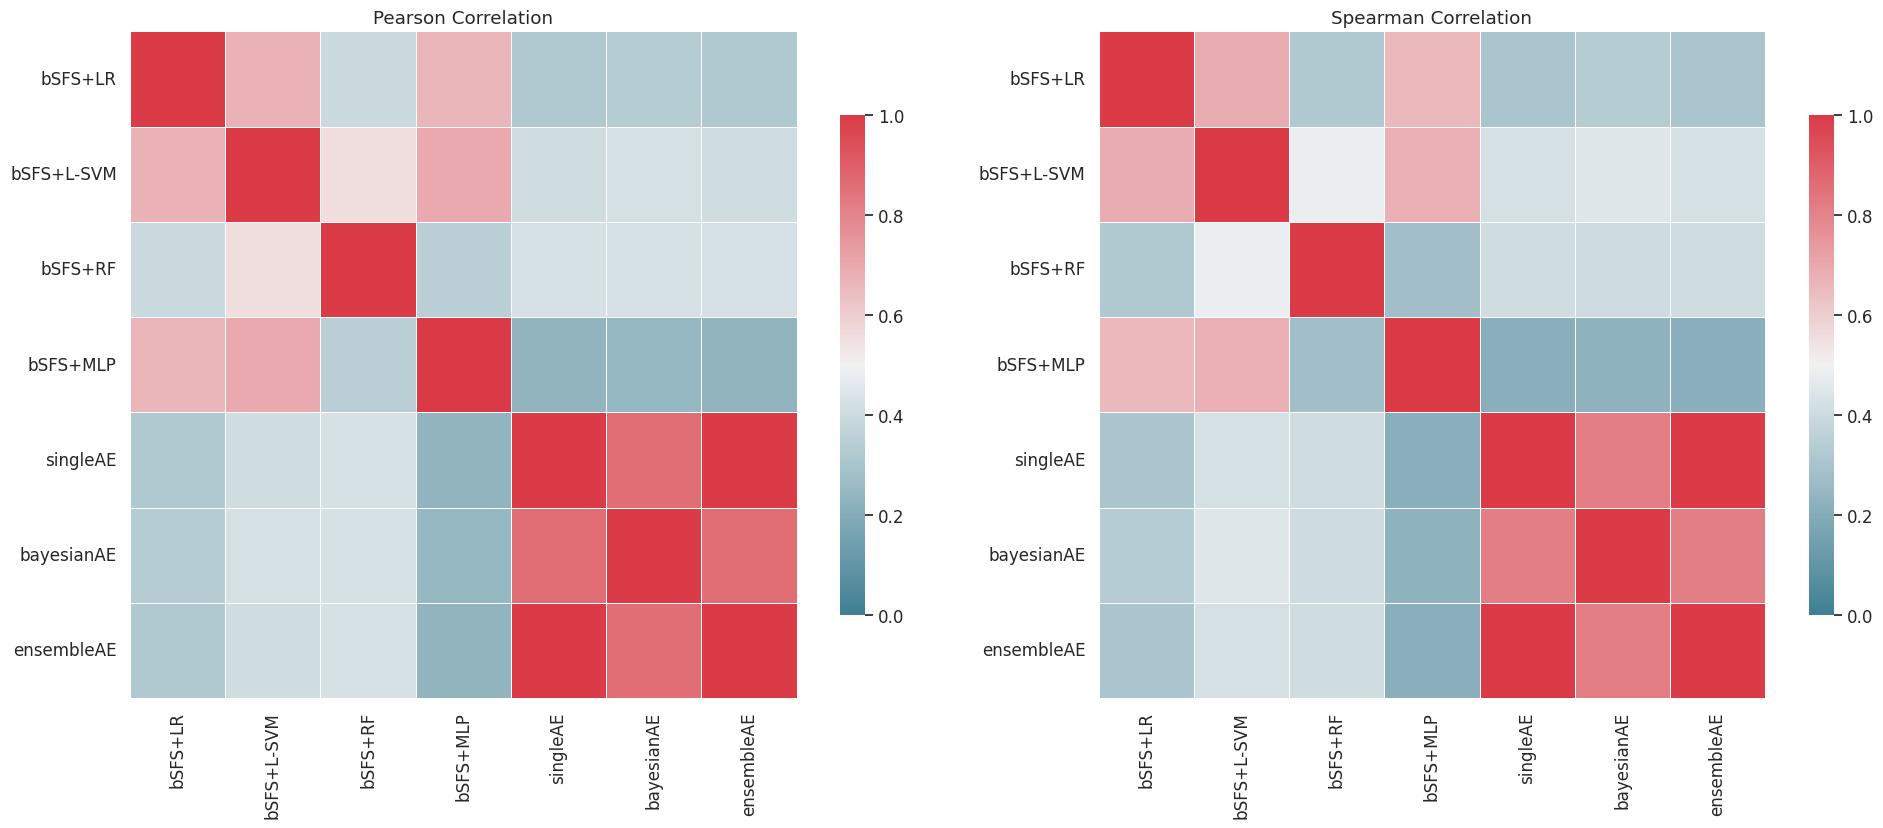

In [54]:
plt.figure(figsize=(20, 8))

# Define a beautiful colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

rename_map = {
    "backwardSFS/LogisticRegression": "bSFS+LR",
    "backwardSFS/SVC": "bSFS+L-SVM",
    "backwardSFS/RandomForestClassifier": "bSFS+RF",
    "backwardSFS/MLPClassifier": "bSFS+MLP",
    "oneDSAE": "singleAE",
    "bayesianDSAE": "bayesianAE",
    "ensembleDSAE": "ensembleAE"
}

pearson_corr_df = pearson_corr_df.rename(index=rename_map, columns=rename_map)
spearman_corr_df = spearman_corr_df.rename(index=rename_map, columns=rename_map)

plt.subplot(1, 2, 1)
sns.heatmap(
    pearson_corr_df, cmap=cmap, square=True, linewidth=0.5,
    cbar_kws={'shrink': 0.75}, vmin=0, vmax=1
)
plt.title("Pearson Correlation")

# --- Right: Spearman ---
plt.subplot(1, 2, 2)
sns.heatmap(
    spearman_corr_df, cmap=cmap, square=True, linewidth=0.5,
    cbar_kws={'shrink': 0.75}, vmin=0, vmax=1
)
plt.title("Spearman Correlation")

plt.tight_layout()

plt.savefig("corr_plot.tif", format="tiff", dpi=600)

plt.show()

In [15]:
print("correlation with all investigated FS methods")

for corr_method, corr_df in {"pearson":pearson_corr_df, "spearman":spearman_corr_df}.items():
    
    print(corr_method)
    print("*"*10)

    subset = corr_df.loc[fs_methods, fs_methods]
    mask = ~np.eye(len(subset), dtype=bool)
    mean_offdiag = subset.where(mask).mean().sort_values()
    
    for infix in ["backward", "DSAE"]:
        methods = [method for method in fs_methods if infix in method]
        print(infix, mean_offdiag.loc[methods].mean())

correlation with all investigated FS methods
pearson
**********
backward 0.4523128585146392
DSAE 0.5359885545693793
spearman
**********
backward 0.4295910591059106
DSAE 0.5201188118811881


In [16]:


for infix in ["backward", "DSAE"]:
    
    print(f"\ncorrelations of features selected by {infix} variants")
    print(infix)
    print("*"*10)
    
    for corr_method, corr_df in {"pearson":pearson_corr_df, "spearman":spearman_corr_df}.items():

        methods = [fs_method for fs_method in fs_methods if infix in fs_method]
        subset = corr_df.loc[methods, methods]

        mask = ~np.eye(len(subset), dtype=bool)
        mean_offdiag = subset.where(mask).mean().sort_values()
        
        print(corr_method)
        print("-"*10)
        print(mean_offdiag)


correlations of features selected by backward variants
backward
**********
pearson
----------
backwardSFS/RandomForestClassifier    0.431627
backwardSFS/MLPClassifier             0.568690
backwardSFS/LogisticRegression        0.576643
backwardSFS/SVC                       0.641067
dtype: float64
spearman
----------
backwardSFS/RandomForestClassifier    0.360571
backwardSFS/MLPClassifier             0.538318
backwardSFS/LogisticRegression        0.556238
backwardSFS/SVC                       0.615942
dtype: float64

correlations of features selected by DSAE variants
DSAE
**********
pearson
----------
bayesianDSAE    0.861592
oneDSAE         0.930796
ensembleDSAE    0.930796
dtype: float64
spearman
----------
bayesianDSAE    0.816290
oneDSAE         0.908145
ensembleDSAE    0.908145
dtype: float64


In [17]:
backward_methods = [fs_method for fs_method in fs_methods if "backward" in fs_method]
dsae_methods = [fs_method for fs_method in fs_methods if "DSAE" in fs_method]

print("cross correlations")
for corr_method, corr_df in {"pearson":pearson_corr_df, "spearman":spearman_corr_df}.items():
    
    print(corr_method)
    print("*"*10)

    subset = corr_df.loc[backward_methods, dsae_methods]

    # mask = ~np.eye(len(subset), dtype=bool)
    # mean_offdiag = subset.where(mask).mean()

    print(subset.mean(axis=1).sort_values())

    print(subset.mean(axis=0).sort_values())

cross correlations
pearson
**********
backwardSFS/MLPClassifier             0.237113
backwardSFS/LogisticRegression        0.323187
backwardSFS/SVC                       0.413421
backwardSFS/RandomForestClassifier    0.426755
dtype: float64
oneDSAE         0.345455
ensembleDSAE    0.345455
bayesianDSAE    0.359447
dtype: float64
spearman
**********
backwardSFS/MLPClassifier             0.215271
backwardSFS/LogisticRegression        0.312854
backwardSFS/RandomForestClassifier    0.407076
backwardSFS/SVC                       0.430458
dtype: float64
oneDSAE         0.335309
ensembleDSAE    0.335309
bayesianDSAE    0.353626
dtype: float64


### Performance Analysis

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


for fs_method, signature in signature_dict.items():
    
    X_df = feats_df[signature]
    y_df = feats_df["label"]
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=100)
    
    roc_aucs = cross_val_score(LogisticRegression(penalty='none', max_iter=10_000), X_df, y_df, cv=cv, scoring="roc_auc")

    print(fs_method, roc_aucs.mean(), roc_aucs.std())
   
  

backwardSFS/LogisticRegression 0.5541458333333333 0.18969953620377375
backwardSFS/SVC 0.6580208333333333 0.18602385616367587
backwardSFS/RandomForestClassifier 0.6218392857142858 0.18998779825288079
backwardSFS/MLPClassifier 0.5808363095238095 0.18790076875806672
oneDSAE 0.6161696428571429 0.19198527734525053
bayesianDSAE 0.5933571428571429 0.19948804621806346
ensembleDSAE 0.6225892857142856 0.19202596600433486


In [23]:
from sklearn.calibration import cross_val_predict

signature1 = signature_dict["backwardSFS/SVC"]
proba1 = cross_val_predict(LogisticRegression(penalty='none', max_iter=10_000), feats_df[signature1], feats_df["label"], cv = 10, method='predict_proba')[:,1]

signature2 = signature_dict["ensembleDSAE"]
proba2 = cross_val_predict(LogisticRegression(penalty='none', max_iter=10_000), feats_df[signature2], feats_df["label"], cv = 10, method='predict_proba')[:,1]

In [30]:
from MLstatkit.stats import Delong_test

Delong_test(feats_df["label"], proba1, proba2)

(-0.46393525174477906, 0.6426941355619556)

In [ ]:
# pivot = pd.crosstab(df_exploded["fs_method"], df_exploded["freq_feats"])
# # Limit to most common features (optional)
# top_features = pivot.sum().sort_values(ascending=False).index
# pivot = pivot[top_features]

# # Plotting
# plt.figure(figsize=(10, 6))
# for i, method in enumerate(pivot.index):
#     for j, feat in enumerate(pivot.columns):
#         if pivot.loc[method, feat]:
#             plt.scatter(j, i, marker='x', color='black')

# plt.yticks(range(len(pivot.index)), pivot.index)
# plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha='right')
# plt.xlabel("Top Frequent Features")
# plt.ylabel("Feature Selection Method")
# # plt.title("Top Features Selected by Different Methods")
# plt.tight_layout()
# plt.show()

In [ ]:
ae_freq_feats = freq_feats[freq_feats.fs_method.isin(["oneDSAE", "bayesianDSAE", "ensembleDSAE"])].freq_feats.to_list()

conv_freq_feats = freq_feats[freq_feats.fs_method.isin(["backwardSFS/LogisticRegression", "backwardSFS/SVC", "backwardSFS/RandomForestClassifier", "backwardSFS/MLPClassifier"])].freq_feats.to_list()

lconv_freq_feats = freq_feats[freq_feats.fs_method.isin(["backwardSFS/LogisticRegression", "backwardSFS/SVC"])].freq_feats.to_list()
nlconv_freq_feats = freq_feats[freq_feats.fs_method.isin(["backwardSFS/RandomForestClassifier", "backwardSFS/MLPClassifier"])].freq_feats.to_list()

In [ ]:
overlap_ae = set(ae_freq_feats[0]).intersection(*ae_freq_feats[1:])
overlap_conv = set(conv_freq_feats[0]).intersection(*conv_freq_feats[1:])

In [ ]:
overlap_ae, overlap_conv

In [ ]:
overlap_lconv = set(lconv_freq_feats[0]).intersection(*lconv_freq_feats[1:])
overlap_nlconv = set(nlconv_freq_feats[0]).intersection(*nlconv_freq_feats[1:])

In [ ]:
overlap_lconv

In [ ]:
overlap_nlconv

In [ ]:
# Figure 3

In [42]:
fs_methods = [
    "backwardSFS/LogisticRegression", "backwardSFS/SVC", 
    "backwardSFS/RandomForestClassifier", "backwardSFS/MLPClassifier", 
    "oneDSAE", "bayesianDSAE", "ensembleDSAE"
]

In [43]:
complexity_df = {"estimator":[], "exe_time":[], "mem_usage":[]}

for fs_method in fs_methods:

    result_dir = os.path.join(OUT_DIR, fs_method, "results_df.csv")
    
    results = pd.read_csv(result_dir, index_col=0)
    
    if "DSAE" in fs_method:
        
        if "bayesian" in fs_method:
            results = results.groupby(by="b").max()
        elif "ensemble" in fs_method:
            results = results.groupby(by="b").sum()
        mem_usage = (results.cpu_mem + results.gpu_mem).to_list()
    else:
        results = results[results.estimator==fs_method.split("/")[-1]]
        mem_usage = results.mem_usage
        
    exe_time = results.exe_time.to_list()
    
    complexity_df["estimator"].append(fs_method)
    complexity_df["exe_time"].append(exe_time)
    complexity_df["mem_usage"].append(mem_usage)

complexity_df = pd.DataFrame(complexity_df)
    

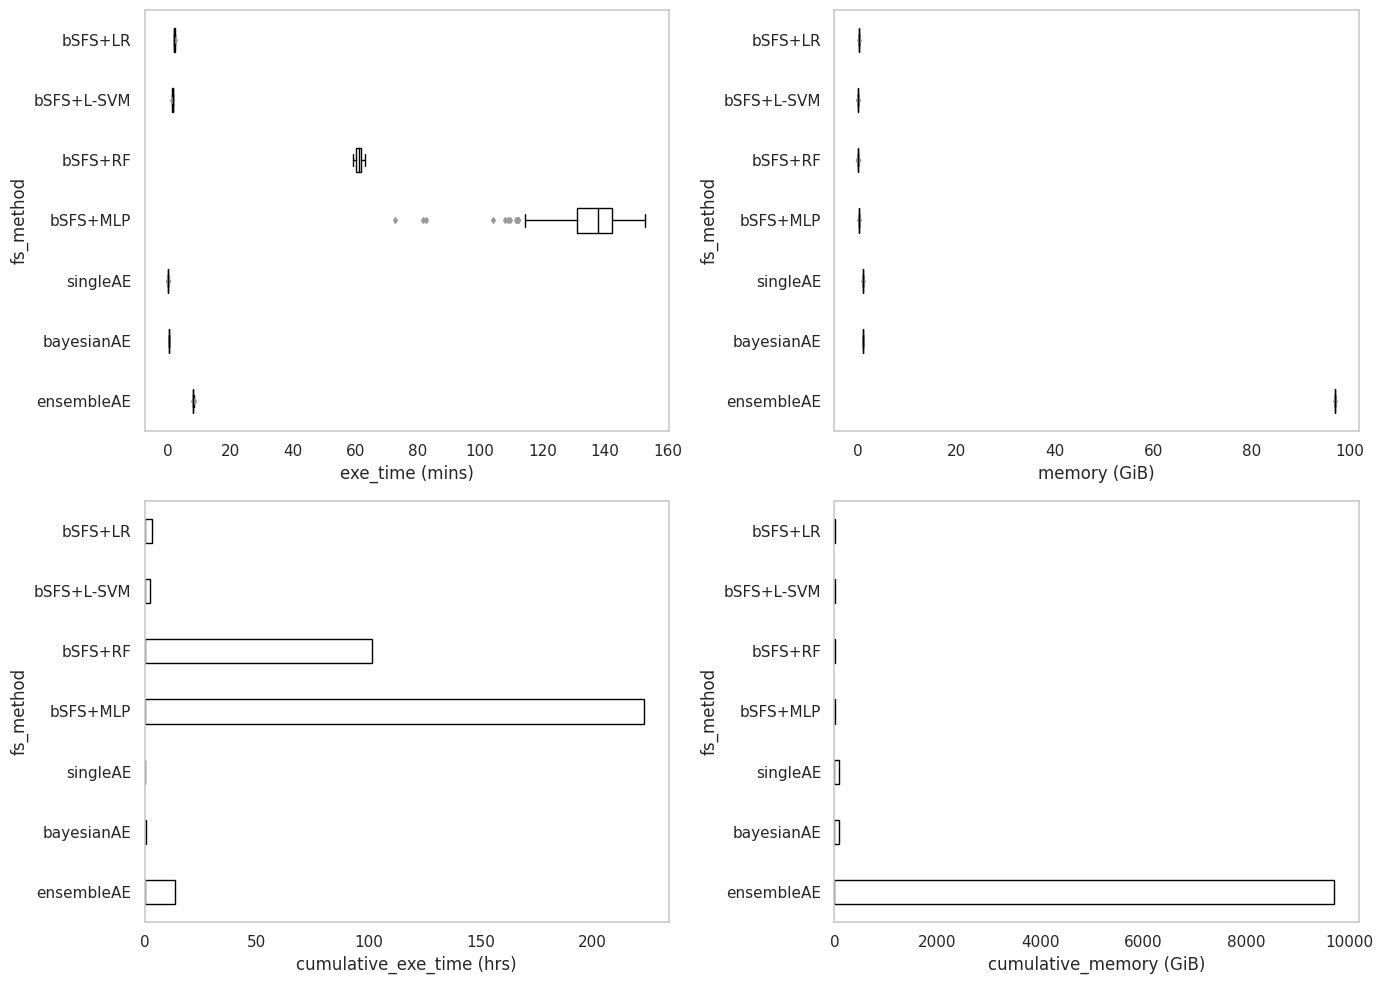

In [44]:
df = complexity_df.copy()
sns.set(style="whitegrid", palette="gray")

fs_methods = [
    "backwardSFS/LogisticRegression", "backwardSFS/SVC", 
    "backwardSFS/RandomForestClassifier", "backwardSFS/MLPClassifier", 
    "oneDSAE", "bayesianDSAE", "ensembleDSAE"
]
label_mapping = {
    "random": "random",
    "backwardSFS/LogisticRegression": "bSFS+LR",
    "backwardSFS/SVC": "bSFS+L-SVM",
    "backwardSFS/RandomForestClassifier": "bSFS+RF",
    "backwardSFS/MLPClassifier": "bSFS+MLP",
    "oneDSAE": "singleAE",
    "bayesianDSAE": "bayesianAE",
    "ensembleDSAE": "ensembleAE"
}


df['fs_method'] = df['estimator'].map(label_mapping)

# Simulated: Load your DataFrame here
# df = pd.read_csv("your_file.csv") or define directly

# Normalize memory values (bytes to GiB)
df['mem_usage'] = df['mem_usage'].apply(lambda x: [float(i) for i in x])

# Compute cumulative stats
df['cumulative_time'] = df['exe_time'].apply(lambda x: sum(x) / 3600)  # hours
df['cumulative_memory'] = df['mem_usage'].apply(lambda x: sum(x) / (1024 ** 3))  # GiB

# Explode lists to individual rows for boxplots
exploded_time = df[['fs_method', 'exe_time']].explode('exe_time')
exploded_time['exe_time'] = exploded_time['exe_time'].astype(float) / 60  # minutes

exploded_mem = df[['fs_method', 'mem_usage']].explode('mem_usage')
exploded_mem['mem_usage'] = exploded_mem['mem_usage'].astype(float) / (1024 ** 3)  # GiB

# Plot
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: Boxplot of Execution time
sns.boxplot(
    x='exe_time', y='fs_method', data=exploded_time, ax=axs[0, 0],
    color='white', fliersize=3, linewidth=1, width=0.4,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color='black')
)
axs[0, 0].set_xlabel("exe_time (mins)")
axs[0, 0].set_ylabel("fs_method")

# Top-right: Boxplot of Memory usage
sns.boxplot(
    x='mem_usage', y='fs_method', data=exploded_mem, ax=axs[0, 1],
    color='white', fliersize=3, linewidth=1, width=0.4,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color='black')
)
axs[0, 1].set_xlabel("memory (GiB)")
axs[0, 1].set_ylabel("fs_method")

# Bottom-left: Cumulative Execution Time
sns.barplot(
    x='cumulative_time', y='fs_method', data=df, ax=axs[1, 0],
    color='white', edgecolor='black', width=0.4
)
axs[1, 0].set_xlabel("cumulative_exe_time (hrs)")
axs[1, 0].set_ylabel("fs_method")

# Bottom-right: Cumulative Memory Usage
sns.barplot(
    x='cumulative_memory', y='fs_method', data=df, ax=axs[1, 1],
    color='white', edgecolor='black', width=0.4
)
axs[1, 1].set_xlabel("cumulative_memory (GiB)")
axs[1, 1].set_ylabel("fs_method")

for ax in axs.flat:
    ax.grid(False)

plt.tight_layout()
plt.savefig("complexity_plot.tif", format="tiff", dpi=600)
plt.show()

In [52]:
df['avg_time'] = df['exe_time'].apply(lambda x: sum(x) / len(x) / 60)  # convert to mins

df['avg_memory'] = df['mem_usage'].apply(lambda x: sum(x) / len(x) / (1024 ** 3))  # convert to GiB

In [117]:
df

,estimator,exe_time,mem_usage,fs_method,cumulative_time,cumulative_memory,avg_time,avg_memory
0,backwardSFS/LogisticRegression,"[119.6313216239214, 119.43492009490728, 122.06...","[76755317.0, 76374461.0, 76374876.0, 76375778....",bSFS+LR,3.377027,7.113484,2.026216,0.071135
1,backwardSFS/SVC,"[88.2425107806921, 86.56401666998863, 82.09658...","[32065804.0, 31474085.0, 31478290.0, 31479648....",bSFS+L-SVM,2.396425,2.932214,1.437855,0.029322
2,backwardSFS/RandomForestClassifier,"[3636.564965136349, 3570.9616866111755, 3552.7...","[50302933.0, 50267323.0, 50280581.0, 50278973....",bSFS+RF,101.792559,4.682472,61.075536,0.046825
3,backwardSFS/MLPClassifier,"[6730.694252125919, 7019.852362535894, 6860.83...","[74172117.0, 74146899.0, 74164009.0, 74112086....",bSFS+MLP,223.075667,6.907110,133.845400,0.069071
4,oneDSAE,"[7.056248895823956, 5.956920199096203, 5.56310...","[1041780060.0, 1041564857.0, 1041556581.0, 104...",singleAE,0.126247,97.002349,0.075748,0.970023
5,bayesianDSAE,"[25.355002902448177, 25.355002902448177, 25.35...","[1041818365.0, 1041818365.0, 1041818365.0, 104...",bayesianAE,0.704306,97.026896,0.422583,0.970269
6,ensembleDSAE,"[503.4271540790796, 481.5502683594823, 489.472...","[104143771691.0, 104143713572.0, 104143773594....",ensembleAE,13.468395,9699.141872,8.081037,96.991419


In [196]:
0.7*60

42.0

In [210]:
100/(30/1024)

3413.3333333333335

In [209]:
np.mean(df[df.estimator.isin(["ensembleDSAE"])].mem_usage.to_list())/(1024**3)

96.99141872281209

In [192]:
np.min(df[df.estimator.isin(["ensembleDSAE"])].exe_time.to_list())/60, np.max(df[df.estimator.isin(["ensembleDSAE"])].exe_time.to_list())/60

(7.9004033529510105, 8.39045256798466)

In [151]:
np.max(df[df.estimator.isin(["singleDSAE"])].exe_time.to_list())

ValueError: zero-size array to reduction operation maximum which has no identity

In [142]:
100/0.03

3333.3333333333335

In [140]:
np.mean(df[df.estimator.isin(["ensembleDSAE"])].mem_usage.to_list())/(1024**3)

96.99141872281209

In [91]:
np.min(df[df.estimator.isin(["backwardSFS/MLPClassifier"])].exe_time.to_list())/60, np.max(df[df.estimator.isin(["backwardSFS/MLPClassifier"])].exe_time.to_list())/60

(72.58558392338455, 152.83797623328869)

In [90]:
np.min(df[df.estimator.isin(["backwardSFS/RandomForestClassifier"])].exe_time.to_list())/60, np.max(df[df.estimator.isin(["backwardSFS/RandomForestClassifier"])].exe_time.to_list())/60

(59.16668297673265, 63.15579272930822)

In [100]:
np.min(df[df.estimator.isin(["ensembleDSAE"])].exe_time.to_list())/60, np.max(df[df.estimator.isin(["ensembleDSAE"])].exe_time.to_list())/60

(7.9004033529510105, 8.39045256798466)

In [104]:
0.5*16

8.0

In [103]:
8.1/0.5

16.2

In [95]:
(2*60)/5

24.0

In [105]:
df

,estimator,exe_time,mem_usage,fs_method,cumulative_time,cumulative_memory,avg_time,avg_memory
0,backwardSFS/LogisticRegression,"[119.6313216239214, 119.43492009490728, 122.06...","[76755317.0, 76374461.0, 76374876.0, 76375778....",bSFS+LR,3.377027,7.113484,2.026216,0.071135
1,backwardSFS/SVC,"[88.2425107806921, 86.56401666998863, 82.09658...","[32065804.0, 31474085.0, 31478290.0, 31479648....",bSFS+L-SVM,2.396425,2.932214,1.437855,0.029322
2,backwardSFS/RandomForestClassifier,"[3636.564965136349, 3570.9616866111755, 3552.7...","[50302933.0, 50267323.0, 50280581.0, 50278973....",bSFS+RF,101.792559,4.682472,61.075536,0.046825
3,backwardSFS/MLPClassifier,"[6730.694252125919, 7019.852362535894, 6860.83...","[74172117.0, 74146899.0, 74164009.0, 74112086....",bSFS+MLP,223.075667,6.907110,133.845400,0.069071
4,oneDSAE,"[7.056248895823956, 5.956920199096203, 5.56310...","[1041780060.0, 1041564857.0, 1041556581.0, 104...",singleAE,0.126247,97.002349,0.075748,0.970023
5,bayesianDSAE,"[25.355002902448177, 25.355002902448177, 25.35...","[1041818365.0, 1041818365.0, 1041818365.0, 104...",bayesianAE,0.704306,97.026896,0.422583,0.970269
6,ensembleDSAE,"[503.4271540790796, 481.5502683594823, 489.472...","[104143771691.0, 104143713572.0, 104143773594....",ensembleAE,13.468395,9699.141872,8.081037,96.991419


In [93]:
np.mean(df[df.estimator.isin(["backwardSFS/LogisticRegression", "backwardSFS/SVC"])].exe_time.to_list())/60

1.7320355875665945

In [55]:
df[df.estimator.isin(["backwardSFS/LogisticRegression", "backwardSFS/SVC", "backwardSFS/RandomForestClassifier", "backwardSFS/MLPClassifier"])]

,estimator,exe_time,mem_usage,fs_method,cumulative_time,cumulative_memory,avg_time,avg_memory
0,backwardSFS/LogisticRegression,"[119.6313216239214, 119.43492009490728, 122.06...","[76755317.0, 76374461.0, 76374876.0, 76375778....",bSFS+LR,3.377027,7.113484,2.026216,0.071135
1,backwardSFS/SVC,"[88.2425107806921, 86.56401666998863, 82.09658...","[32065804.0, 31474085.0, 31478290.0, 31479648....",bSFS+L-SVM,2.396425,2.932214,1.437855,0.029322
2,backwardSFS/RandomForestClassifier,"[3636.564965136349, 3570.9616866111755, 3552.7...","[50302933.0, 50267323.0, 50280581.0, 50278973....",bSFS+RF,101.792559,4.682472,61.075536,0.046825
3,backwardSFS/MLPClassifier,"[6730.694252125919, 7019.852362535894, 6860.83...","[74172117.0, 74146899.0, 74164009.0, 74112086....",bSFS+MLP,223.075667,6.907110,133.845400,0.069071


In [ ]:
complexity_df.groupby(by=["fs_method", "similarity_measure", "top_k"]).mean().xs("ensembleDSAE")

In [ ]:
df['avg_time'] = df['exe_time'].apply(lambda x: sum(x) / len(x) / 60)  # convert to mins

df['avg_memory'] = df['mem_usage'].apply(lambda x: sum(x) / len(x) / (1024 ** 3))  # convert to GiB

In [ ]:
df

### Statistical Analysis (Wilcoxon Signed Rank Test)

##### <> 1. SFS+LR v/s Ensemble AE
- global, and Kuncheva Top-5

In [ ]:
similarity_measure="global_spearman"
top_k = "NA"

In [ ]:
x = stability_df[(stability_df.fs_method=="backwardSFS/LogisticRegression")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()
y = stability_df[(stability_df.fs_method=="random")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()

sns_data = pd.DataFrame({"LR":x, "ensembleAE":y})
sns.boxplot(data=sns_data)

print("Wilcoxon Signed Rank Test: p-value = ", stats.wilcoxon(x, y).pvalue)

print("Paired T-Test: ", "normality, x-", stats.shapiro(x).pvalue, ",y-", stats.shapiro(y).pvalue, "ttest-", stats.ttest_rel(x, y).pvalue)

In [ ]:
similarity_measure="kuncheva"
top_k = 5

In [ ]:
x = stability_df[(stability_df.fs_method=="backwardSFS/LogisticRegression")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()
y = stability_df[(stability_df.fs_method=="ensembleDSAE")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()

sns_data = pd.DataFrame({"LR":x, "ensembleAE":y})
sns.boxplot(data=sns_data)

print("Wilcoxon Signed Rank Test: p-value = ", stats.wilcoxon(x, y).pvalue)

print("Paired T-Test: ", "normality, x-", stats.shapiro(x).pvalue, ",y-", stats.shapiro(y).pvalue, "ttest-", stats.ttest_rel(x, y).pvalue)

##### <> 1. bayesian AE v/s Ensemble AE
- global, and Kuncheva Top-5

In [ ]:
similarity_measure="global_spearman"
top_k = "NA"

In [ ]:
x = stability_df[(stability_df.fs_method=="bayesianDSAE")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()
y = stability_df[(stability_df.fs_method=="ensembleDSAE")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()

sns_data = pd.DataFrame({"bayesianAE":x, "ensembleAE":y})
sns.boxplot(data=sns_data)

print("Wilcoxon Signed Rank Test: p-value = ", stats.wilcoxon(x, y).pvalue)

print("Paired T-Test: ", "normality, x-", stats.shapiro(x).pvalue, ",y-", stats.shapiro(y).pvalue, "ttest-", stats.ttest_rel(x, y).pvalue)

In [ ]:
similarity_measure="kuncheva"
top_k = 5

In [ ]:
x = stability_df[(stability_df.fs_method=="bayesianDSAE")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()
y = stability_df[(stability_df.fs_method=="ensembleDSAE")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()

sns_data = pd.DataFrame({"LR":x, "ensembleAE":y})
sns.boxplot(data=sns_data)

print("Wilcoxon Signed Rank Test: p-value = ", stats.wilcoxon(x, y).pvalue)

print("Paired T-Test: ", "normality, x-", stats.shapiro(x).pvalue, ",y-", stats.shapiro(y).pvalue, "ttest-", stats.ttest_rel(x, y).pvalue)

### Complexity Analysis

In [ ]:
DATA_DIR = r"outputs"
FS_METHODS = ["backwardSFS", "oneDSAE", "bayesianDSAE", "ensembleDSAE"]

In [ ]:
sfs_results_df = pd.read_csv(os.path.join(DATA_DIR, "backwardSFS/results_df.csv"), index_col=0)
sAE_results_df = pd.read_csv(os.path.join(DATA_DIR, "oneDSAE", "results_df.csv"))
bAE_results_df = pd.read_csv(os.path.join(DATA_DIR, "bayesianDSAE", "results_df.csv"))
eAE_results_df = pd.read_csv(os.path.join(DATA_DIR, "ensembleDSAE", "results_df.csv"))

In [ ]:
time_df = {"fs_method":[], "# runs":[], "exe_time":[]}

In [ ]:
sAE_time_df = pd.DataFrame({"# runs":sAE_results_df.groupby(["outer_seed"]).first().index.to_numpy(), "exe_time":sAE_results_df.groupby(["outer_seed"]).first()["exe_time"].to_numpy()})
time_df["fs_method"] += ['singleAE'] * len(sAE_time_df)
time_df["# runs"] += list(sAE_time_df["# runs"].to_numpy() + 1)
time_df["exe_time"] += list(sAE_time_df["exe_time"].to_numpy())

bAE_time_df = pd.DataFrame({"# runs":bAE_results_df.groupby(["outer_seed"]).first().index.to_numpy(), "exe_time":bAE_results_df.groupby(["outer_seed"]).first()["exe_time"].to_numpy()})
time_df["fs_method"] += ['bayesianAE'] * len(bAE_time_df)
time_df["# runs"] += list(bAE_time_df["# runs"].to_numpy() + 1)
time_df["exe_time"] += list(bAE_time_df["exe_time"].to_numpy())

eAE_time_df = pd.DataFrame({"# runs":eAE_results_df.groupby(["outer_seed", "b"]).first().groupby("outer_seed").sum().index.to_numpy(), "exe_time":eAE_results_df.groupby(["outer_seed", "b"]).first().groupby("outer_seed").sum()["exe_time"].to_numpy()})
time_df["fs_method"] += ['ensembleAE'] * len(eAE_time_df)
time_df["# runs"] += list(eAE_time_df["# runs"].to_numpy()+1)
time_df["exe_time"] += list(eAE_time_df["exe_time"].to_numpy())

In [ ]:
def acronym(estimator):

    acronym = ""
    
    if estimator=="LogisticRegression":
        acronym = "SFS+LR"
    elif estimator=="SVC":
        acronym = "SFS+L-SVM"
    elif estimator=="RandomForestClassifier":
        acronym = "SFS+RF"
    elif estimator=="MLPClassifier":
        acronym = "SFS+MLP"
    else:
        print("Invalid estimator name")

    return acronym

In [ ]:


for estimator in ["LogisticRegression", "SVC", "RandomForestClassifier", "MLPClassifier"]:

    _df = sfs_results_df.groupby(["estimator","outer_seed"]).sum().loc[estimator]
    sfs_time_df = pd.DataFrame({"# runs":_df.index.to_numpy()+1, "exe_time":_df["exe_time"].to_numpy()})

    time_df["fs_method"] += [acronym(estimator)] * len(sfs_time_df)
    time_df["# runs"] += list(sfs_time_df["# runs"].to_numpy()+1)
    time_df["exe_time"] += list(sfs_time_df["exe_time"].to_numpy())


    

In [ ]:
time_df = pd.DataFrame(time_df)
time_df["cumulative_exe_time"] = time_df.groupby('fs_method')['exe_time'].cumsum()

display(time_df)

In [ ]:
time_df['exe_time (mins)'] = time_df['exe_time']/60
time_df['cumulative_exe_time (mins)'] = time_df['cumulative_exe_time']/60

In [ ]:
time_df

In [ ]:
sns.boxplot(data=time_df, x='exe_time (mins)', y='fs_method', width=.2, fill=False, color=".1")

In [ ]:
# sns.barplot(data=time_df, x='cumulative_exe_time', y='fs_method', width=.2, fill=False, color=".4")
# sns.boxplot(data=time_df, x='exe_time', y='fs_method', width=.2, fill=False, color=".4")
sns.barplot(data=time_df, x='cumulative_exe_time (mins)', y='fs_method', width=.2, fill=False, color=".1", errorbar=None)

In [ ]:
sns.lineplot(x='# runs', y=)

In [ ]:
eAE_results_df.groupby(["outer_seed", "b"]).first().groupby("outer_seed").sum()["exe_time"]

In [ ]:
eAE_results_df.groupby(["outer_seed"]).mean()

In [ ]:
eAE_results_df.groupby(["outer_seed"]).sum()

In [ ]:
eAE_results_df.groupby(["outer_seed","b", "permute_seed"]).sum()

In [ ]:
eAE_results_df.groupby(["outer_seed", "permute_seed"]).sum()

In [ ]:
bAE_results_df.groupby("outer_seed").max()

In [ ]:
sAE_results_df.groupby("outer_seed").max()

In [ ]:
for fs_method in FS_METHODS:

    results_df = pd.read_csv(os.path.join(DATA_DIR, fs_method, "results_df.csv"))

    display(results_df.head(10))
    